In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from jax import config
config.update('jax_enable_x64', True)
import matplotlib.pyplot as plt
import corner
import pandas as pd

In [2]:
# RBF kernel
def cov_rbf(x, tau, alpha, sigma):
    dx = x[:,None] - x[None, :]
    return alpha**2 * jnp.exp(-0.5 * (dx / tau)**2) + jnp.diag(sigma**2)

Here the data is given by $y = f(x) + \epsilon$, where
$$
f(x) =  \begin{cases}
c\,(1 - \delta), &|x| < 3\\
c, &\mathrm{otherwise}
\end{cases}
$$ and $\epsilon$ is drawn from a Gaussian process. We infer $c$, $\delta$, and GP hyperparameters and see what happens.

## signal (box + correlated noise)

In [3]:
x = np.linspace(-10, 10, 100)
y_true = np.where(np.abs(x)<3, 0.7, 1.)

In [4]:
tau = 1.
alpha = 0.05
sigma = 0.05

In [5]:
mv = dist.MultivariateNormal(loc=0., covariance_matrix=cov_rbf(x, tau, alpha, jnp.ones_like(x)*sigma))

In [6]:
y = y_true + mv.sample(random.PRNGKey(0))

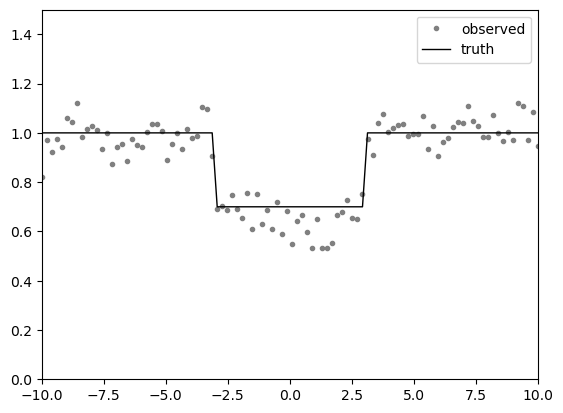

In [7]:
plt.xlim(-10, 10)
plt.ylim(0, 1.5)
plt.plot(x, y, '.', label='observed', color='gray')
plt.plot(x, y_true, '-', label='truth', color='k', lw=1)
plt.legend(loc='best');

## successful GP fit

In [8]:
from numpyro.infer import Predictive
def predictions(samples, model, x, y):
    pred = Predictive(model, samples)
    preds = pred(rng_key, x=x, yobs=y)
    preds['gppred'] = preds['obs'] - preds['ymodel']
    return preds

In [9]:
def model_gp(x, yobs):
    norm = numpyro.sample("norm", dist.Uniform(0., 1.5))
    depth = numpyro.sample("depth", dist.Uniform(0., 1.))
    sigma = numpyro.sample("sigma", dist.Exponential(10.))
    ymodel = numpyro.deterministic("ymodel", jnp.where(jnp.abs(x)<3., norm*(1.-depth), norm))
    
    lna = numpyro.sample("lna", dist.Uniform(-5, -1))
    lntau = numpyro.sample("lntau", dist.Uniform(-2, 2))
    cov = cov_rbf(x, jnp.exp(lntau), jnp.exp(lna), sigma*jnp.ones_like(x))
    
    numpyro.sample("obs", dist.MultivariateNormal(loc=ymodel, covariance_matrix=cov), obs=yobs)

In [10]:
kernel = numpyro.infer.NUTS(model_gp)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=500, num_samples=500)

In [11]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, x, y)

sample: 100%|█████████████████████████████████████| 1000/1000 [00:09<00:00, 102.05it/s, 3 steps of size 4.33e-01. acc. prob=0.91]


In [12]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     depth      0.32      0.03      0.33      0.27      0.36    217.32      1.00
       lna     -3.33      0.43     -3.30     -4.09     -2.75    154.35      1.00
     lntau     -0.23      0.51     -0.29     -1.16      0.51    307.69      1.00
      norm      0.99      0.02      0.99      0.96      1.01    177.74      1.00
     sigma      0.06      0.01      0.06      0.05      0.06    293.39      1.00

Number of divergences: 0


In [13]:
samples_gp = mcmc.get_samples()

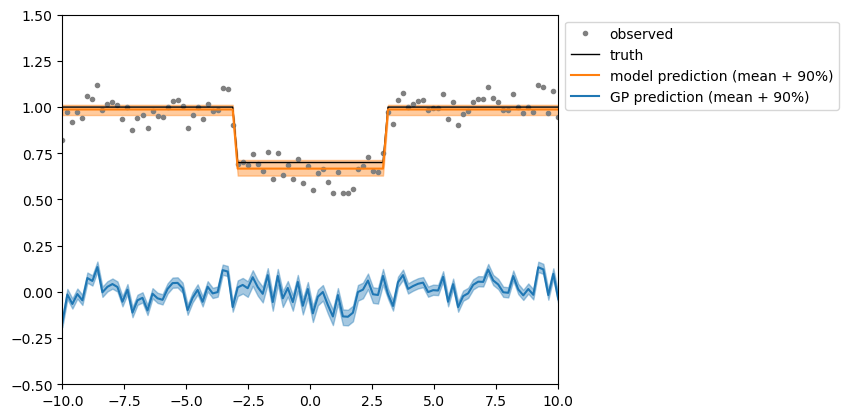

In [14]:
preds = predictions(samples_gp, model_gp, x, y)
plt.xlim(-10, 10)
plt.ylim(-0.5, 1.5)
plt.plot(x, y, '.', label='observed', color='gray')
plt.plot(x, y_true, '-', label='truth', color='k', lw=1)
plt.plot(x, np.mean(preds['ymodel'], axis=0), color='C1', alpha=1, label='model prediction (mean + 90%)')
plt.fill_between(x, *np.percentile(preds['ymodel'], [5,95], axis=0), color='C1', alpha=0.4)
plt.plot(x, np.mean(preds['gppred'], axis=0), color='C0', alpha=1, label='GP prediction (mean + 90%)')
plt.fill_between(x, *np.percentile(preds['gppred'], [5,95], axis=0), color='C0', alpha=0.4)
plt.legend(loc='best', bbox_to_anchor=(1,1));

## GP fit, forcing large alpha and tau

In [15]:
def model_gp_offset(x, yobs):
    norm = numpyro.sample("norm", dist.Uniform(0., 1.5))
    depth = numpyro.sample("depth", dist.Uniform(0., 1.))
    sigma = numpyro.sample("sigma", dist.Exponential(10.))
    ymodel = numpyro.deterministic("ymodel", jnp.where(jnp.abs(x)<3., norm*(1.-depth), norm))
    
    lna = numpyro.sample("lna", dist.Uniform(-1, 1))
    lntau = numpyro.sample("lntau", dist.Uniform(0, 4))
    cov = cov_rbf(x, jnp.exp(lntau), jnp.exp(lna), sigma*jnp.ones_like(x))
    
    numpyro.sample("obs", dist.MultivariateNormal(loc=ymodel, covariance_matrix=cov), obs=yobs)

In [16]:
kernel = numpyro.infer.NUTS(model_gp_offset)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=500, num_samples=500)

In [17]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, x, y)

sample: 100%|█████████████████████████████████████| 1000/1000 [00:39<00:00, 25.48it/s, 31 steps of size 6.34e-02. acc. prob=0.93]


In [18]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     depth      0.50      0.22      0.43      0.22      0.86    150.63      1.01
       lna     -0.59      0.34     -0.68     -1.00     -0.10    373.11      1.00
     lntau      3.59      0.34      3.67      3.13      3.99    330.60      1.00
      norm      0.81      0.32      0.79      0.35      1.31    205.88      1.01
     sigma      0.06      0.00      0.06      0.06      0.07    268.36      1.00

Number of divergences: 0


In [19]:
samples_gp_offset = mcmc.get_samples()

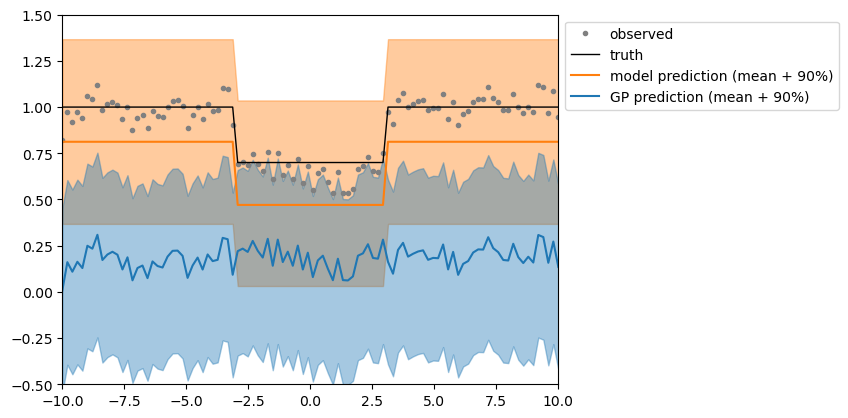

In [20]:
preds = predictions(samples_gp_offset, model_gp_offset, x, y)
plt.xlim(-10, 10)
plt.ylim(-0.5, 1.5)
plt.plot(x, y, '.', label='observed', color='gray')
plt.plot(x, y_true, '-', label='truth', color='k', lw=1)
plt.plot(x, np.mean(preds['ymodel'], axis=0), color='C1', alpha=1, label='model prediction (mean + 90%)')
plt.fill_between(x, *np.percentile(preds['ymodel'], [5,95], axis=0), color='C1', alpha=0.4)
plt.plot(x, np.mean(preds['gppred'], axis=0), color='C0', alpha=1, label='GP prediction (mean + 90%)')
plt.fill_between(x, *np.percentile(preds['gppred'], [5,95], axis=0), color='C0', alpha=0.4)
plt.legend(loc='best', bbox_to_anchor=(1,1));

###  normalization and GP mean are completely degenerate...

In [21]:
keys = ['depth', 'lna', 'lntau', 'norm', 'sigma']
smp_df = pd.DataFrame(dict(zip(keys, [samples_gp_offset[key] for key in keys])))

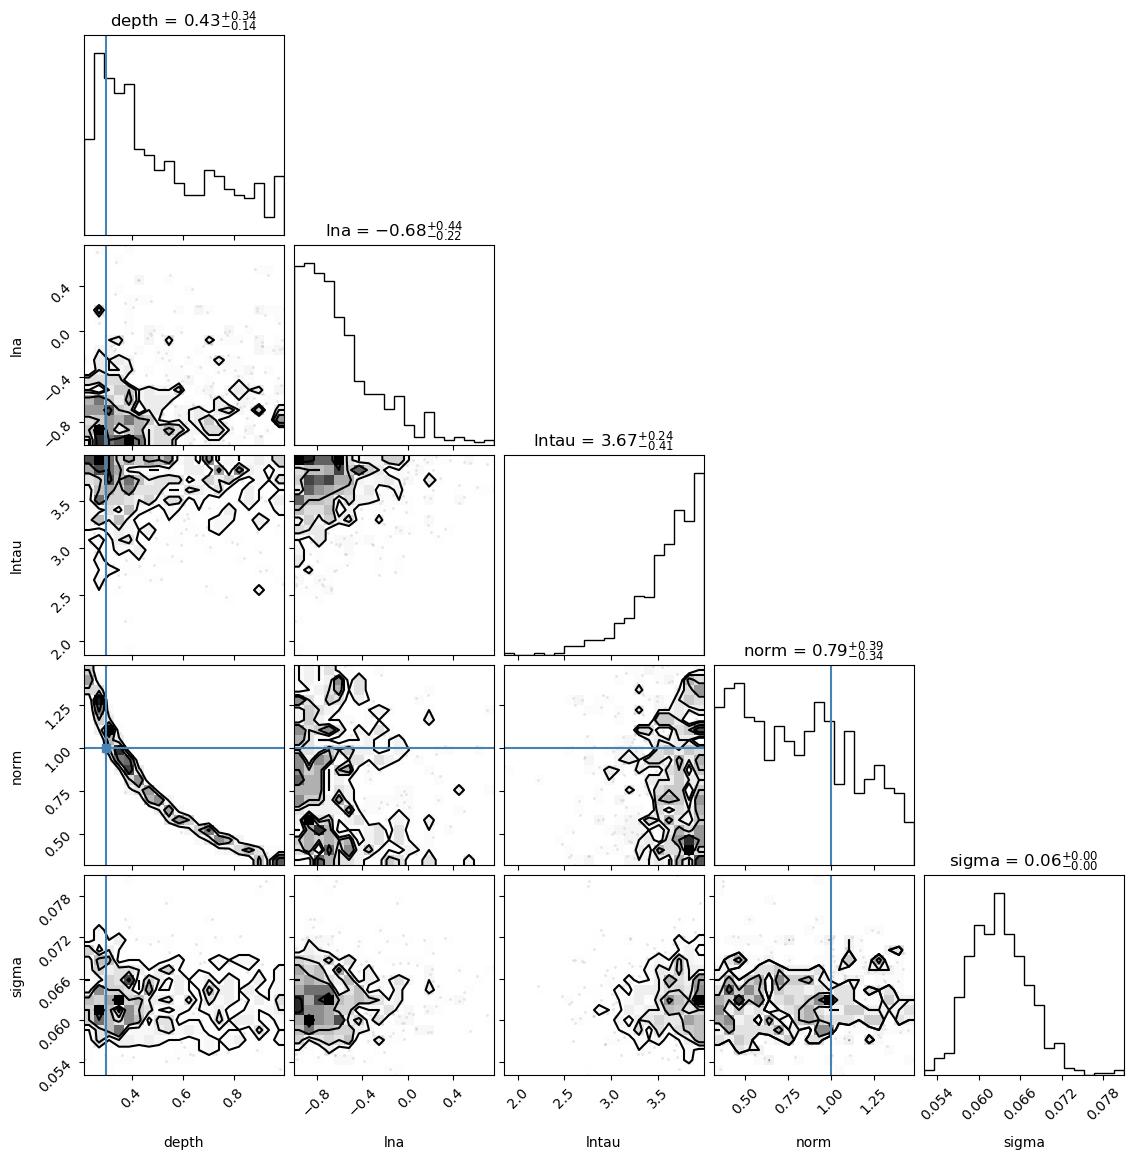

In [23]:
fig = corner.corner(smp_df, labels=keys, show_titles=True, title_fmt='.2f', 
                    truths=[0.3, np.log(alpha), np.log(tau), 1., sigma]);